In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns

sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

mouse_path = "E:/Mouse_M1/"
opossum_path = "E:/Opossum_M1/"

adata_mouse = sc.read_h5ad(mouse_path + "Mouse_M1_All.h5ad")
adata_opossum = sc.read_h5ad(opossum_path + "Opossum_M1_All.h5ad")

In [2]:
shared_genes = [gene for gene in adata_mouse.var_names if gene.upper() in adata_opossum.var_names]
np.savetxt("E:/Mouse_M1/Mouse_Opossum_Shared_Genes.csv", shared_genes, fmt="%s")

In [3]:
def subsample_adata(adata, number, key="leiden_intra"):
    mask = np.zeros(adata.shape[0])
    unique = np.unique(adata.obs[key])
    for un in unique:
        idx = np.where(adata.obs[key] == un)[0]
        if idx.size < number:
            print("Warning: {0} contains fewer cells than minimum, taking all cells.".format(un))
            mask[idx] = 1
        else:
            rand_idx = np.random.permutation(idx)[:number]
            mask[rand_idx] = 1
    return adata[mask == 1, :]

In [4]:
del adata_mouse.uns
del adata_mouse.obsm
del adata_mouse.varm
del adata_mouse.obsp
adata_mouse.obs["species"] = ["mouse"] * adata_mouse.shape[0]
adata_mouse = adata_mouse[adata_mouse.obs["class"] == "glutamatergic", :]
adata_glut_mouse = sc.read_h5ad(mouse_path + "Mouse_M1_Glut_Clustered.h5ad")
adata_mouse.obs["leiden_intra"] = adata_glut_mouse.obs["leiden"]
del adata_glut_mouse

shared_genes = np.loadtxt("E:/Mouse_M1/Mouse_Opossum_Shared_Genes.csv", dtype=str)
adata_mouse = adata_mouse[:, shared_genes]
sc.pp.filter_cells(adata_mouse, min_genes=700)

C:\Users\TLab\AppData\Local\Temp\ipykernel_6540\3306579342.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mouse.obs["leiden_intra"] = adata_glut_mouse.obs["leiden"]
C:\Ryan\GitHub\scanpy\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [5]:
adata_mouse = subsample_adata(adata_mouse, 500, key="leiden_intra")

In [6]:
del adata_opossum.uns
del adata_opossum.obsm
del adata_opossum.varm
del adata_opossum.obsp
adata_opossum = adata_opossum[adata_opossum.obs["class"] == "glutamatergic", :]
adata_glut_opossum = sc.read_h5ad(opossum_path + "Opossum_M1_Glut_Clustered.h5ad")
adata_opossum.obs["leiden_intra"] = adata_glut_opossum.obs["leiden"]
adata_opossum = adata_opossum[adata_opossum.obs["leiden_intra"].astype(str) != "nan", :]
adata_opossum.obs["leiden_intra"] = adata_opossum.obs["leiden_intra"].astype(str)
del adata_glut_opossum

shared_genes = np.loadtxt("E:/Mouse_M1/Mouse_Opossum_Shared_Genes.csv", dtype=str)
shared_genes = np.array([gene.upper() for gene in shared_genes], dtype=str)
adata_opossum = adata_opossum[:, shared_genes]
sc.pp.filter_cells(adata_opossum, min_genes=700)

C:\Users\TLab\AppData\Local\Temp\ipykernel_6540\3841189088.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_opossum.obs["leiden_intra"] = adata_glut_opossum.obs["leiden"]
C:\Users\TLab\AppData\Local\Temp\ipykernel_6540\3841189088.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_opossum.obs["leiden_intra"] = adata_opossum.obs["leiden_intra"].astype(str)


filtered out 2427 cells that have less than 700 genes expressed


C:\Ryan\GitHub\scanpy\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [8]:
adata_opossum = subsample_adata(adata_opossum, 500, key="leiden_intra")

In [9]:
var_names_lower = adata_mouse.var_names
var_names_upper = []
for name in var_names_lower:
    var_names_upper.append(name.upper())
adata_mouse.var_names = var_names_upper

Concatenate AnnData objects and find highly variable genes

In [10]:
adata = adata_mouse.concatenate(adata_opossum, batch_key="concat")

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [12]:
adata

AnnData object with n_obs × n_vars = 17033 × 10563
    obs: 'class_label', 'cluster_label', 'batch', 'n_counts', 'leiden', 'class', 'species', 'leiden_intra', 'n_genes', 'n_UMIs', 'doublet', 'doublet_score', 'concat'
    var: 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1'

Perform PCA with Harmony batch-correction and cluster together

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [13]:
adata.obs

,class_label,cluster_label,batch,n_counts,leiden,class,species,leiden_intra,n_genes,n_UMIs,doublet,doublet_score,concat,leiden_inter
pBICCNsMMrMOpRAiF003d190318_AACCAACTCTGCCCTA-0,Glutamatergic,L6 CT Cpa6,pBICCNsMMrMOpRAiF003d190318,18342.0,0,glutamatergic,mouse,10,3989,NaN,NaN,NaN,0,0
pBICCNsMMrMOpRAiF003d190318_AAGTACCCACAACGCC-0,Glutamatergic,L6b Col6a1,pBICCNsMMrMOpRAiF003d190318,24293.0,21,glutamatergic,mouse,15,4395,NaN,NaN,NaN,0,9
pBICCNsMMrMOpRAiF003d190318_AATGCCAGTAGTACGG-0,Glutamatergic,L6 CT Cpa6,pBICCNsMMrMOpRAiF003d190318,14873.0,0,glutamatergic,mouse,8,3528,NaN,NaN,NaN,0,0
pBICCNsMMrMOpRAiF003d190318_ACGCACGCATGGAAGC-0,Glutamatergic,L6b Ror1,pBICCNsMMrMOpRAiF003d190318,17945.0,21,glutamatergic,mouse,15,3705,NaN,NaN,NaN,0,9
pBICCNsMMrMOpRAiF003d190318_ACTGTCCAGGATACAT-0,Glutamatergic,L6b Col6a1,pBICCNsMMrMOpRAiF003d190318,17435.0,0,glutamatergic,mouse,13,2956,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTGCTCTTC-1-NW_TX0092-8-1,NaN,NaN,NW_TX0092-8,14090.0,10,glutamatergic,opossum,9,3837,17687.0,0.0,0.193627,1,12
TTTGATCAGGCTCTAT-1-NW_TX0092-8-1,NaN,NaN,NW_TX0092-8,6191.0,12,glutamatergic,opossum,12,2613,7798.0,0.0,0.119802,1,16
TTTGATCTCATTTCCA-1-NW_TX0092-8-1,NaN,NaN,NW_TX0092-8,4010.0,2,glutamatergic,opossum,5,2074,5103.0,0.0,0.177947,1,4
TTTGATCTCCATCTAT-1-NW_TX0092-8-1,NaN,NaN,NW_TX0092-8,8292.0,14,glutamatergic,opossum,13,3059,10534.0,0.0,0.132222,1,8


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


2023-06-07 13:15:40,289 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-06-07 13:15:45,394 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-06-07 13:15:45,564 - harmonypy - INFO - Iteration 1 of 20
2023-06-07 13:15:54,254 - harmonypy - INFO - Iteration 2 of 20
2023-06-07 13:16:03,181 - harmonypy - INFO - Iteration 3 of 20
2023-06-07 13:16:12,187 - harmonypy - INFO - Iteration 4 of 20
2023-06-07 13:16:21,188 - harmonypy - INFO - Iteration 5 of 20
2023-06-07 13:16:26,435 - harmonypy - INFO - Iteration 6 of 20
2023-06-07 13:16:33,596 - harmonypy - INFO - Iteration 7 of 20
2023-06-07 13:16:38,509 - harmonypy - INFO - Iteration 8 of 20
2023-06-07 13:16:47,461 - harmonypy - INFO - Iteration 9 of 20
2023-06-07 13:16:52,136 - harmonypy - INFO - Iteration 10 of 20
2023-06-07 13:16:59,920 - harmonypy - INFO - Iteration 11 of 20
2023-06-07 13:17:05,485 - harmonypy - INFO - Iteration 12 of 20
2023-06-07 13:17:10,191 - harmonypy - INFO - Iteration 13 of

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_inter', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


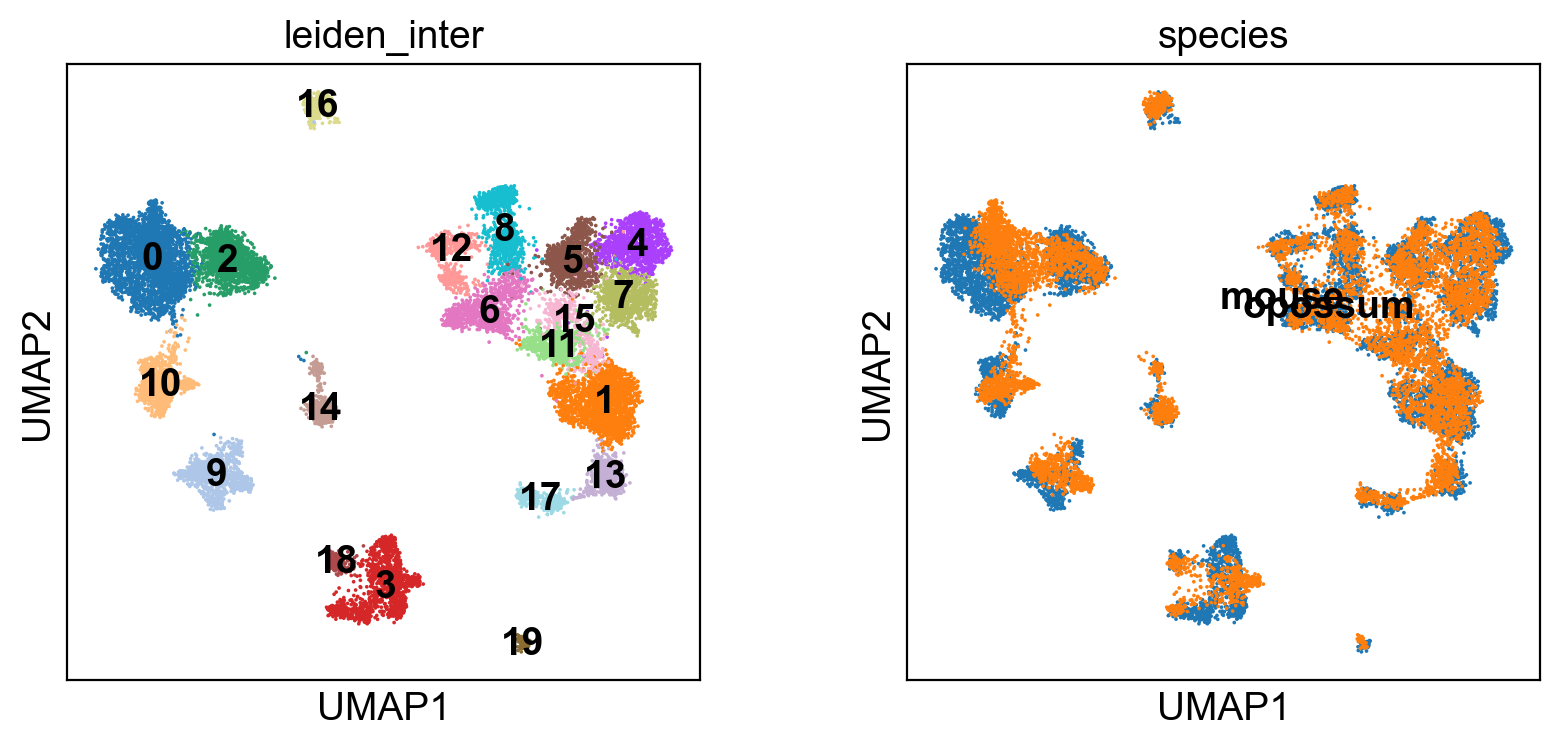

In [31]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, ["batch", "species"], theta=[6, 6], max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata, key_added="leiden_inter")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden_inter", "species"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


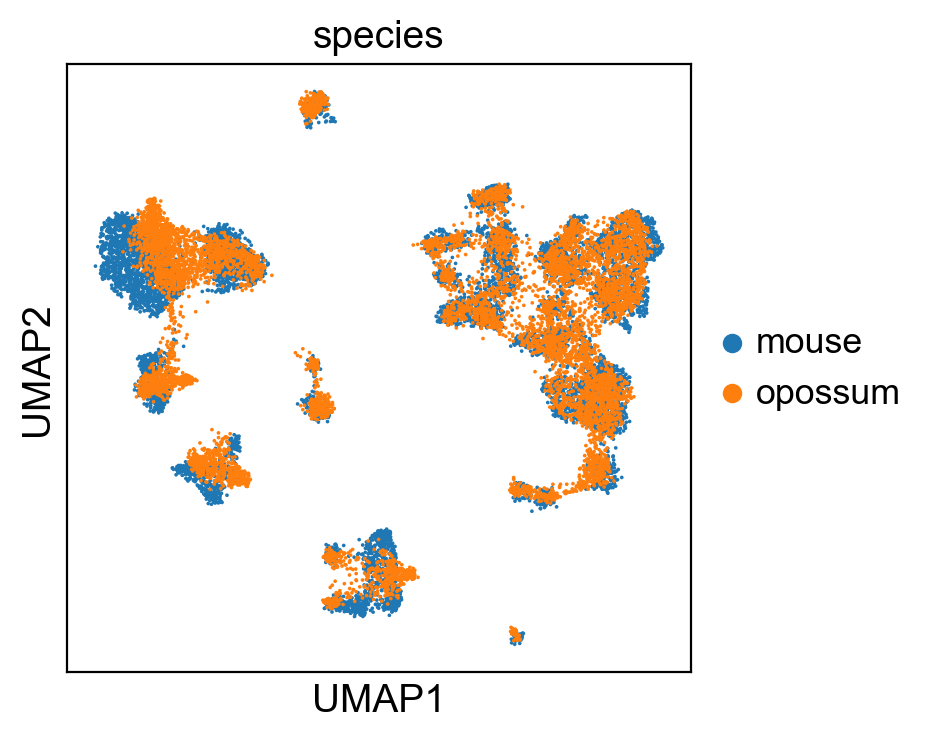

In [34]:
sc.pl.umap(adata, color=["species"])

C:\Ryan\GitHub\scanpy\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


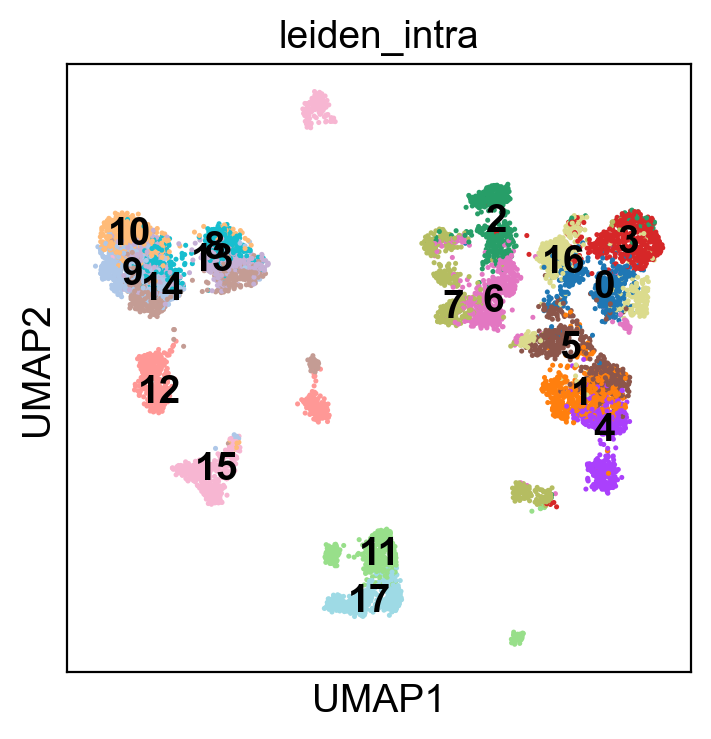

In [32]:
sc.pl.umap(adata[adata.obs["species"]=="mouse", :], color=["leiden_intra"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


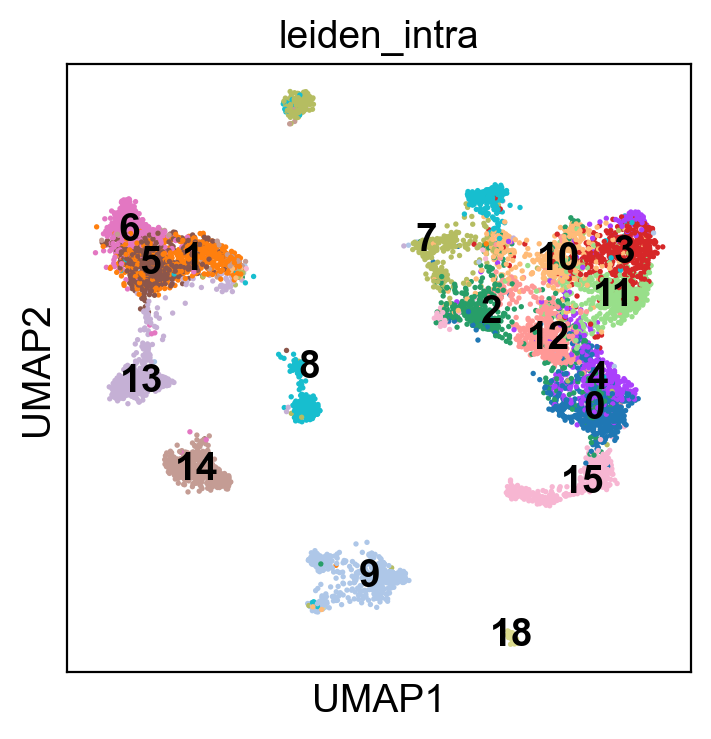

In [33]:
sc.pl.umap(adata[adata.obs["species"]=="opossum", :], color=["leiden_intra"], legend_loc="on data")

In [19]:
n_trees, n_top_genes, n_binary_genes, n_genes_eval = 1000, 15, 10, 6

results = ns.NSForest(
                    adata, 
                    cluster_header="leiden_inter", 
                    cluster_list=["2"], 
                    n_trees=n_trees, 
                    n_top_genes=n_top_genes, 
                    n_binary_genes=n_binary_genes, 
                    n_genes_eval=n_genes_eval, 
                        )

Preparing data...
--- 0.002991914749145508 seconds ---
Calculating medians...
--- 4.7712562084198 seconds ---
Number of clusters to evaluate: 1
1 out of 1:
	2
	['NTNG1', 'TMEM163']
	0.7978818883503859
--- 210.0851058959961 seconds ---


In [28]:
results["binary_genes"][0]

['CACNA1H',
 'TRPC4',
 'NTNG1',
 'POU3F1',
 'SORCS1',
 'TMEM163',
 'LPP',
 'KCNN2',
 'RHBDL3',
 'CORO6']

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


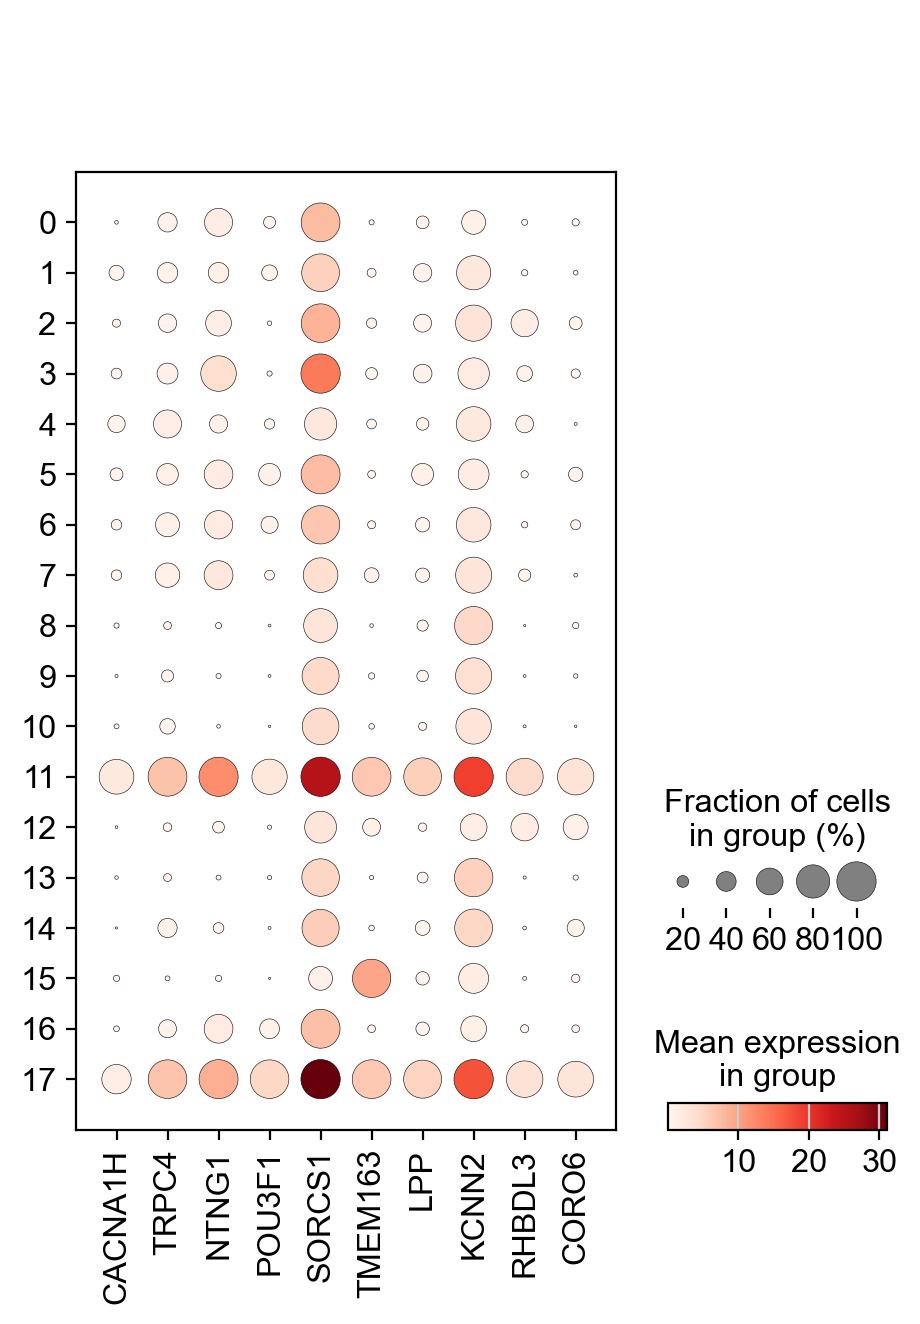

In [30]:
sc.pl.dotplot(
    adata_mouse, 
    results["binary_genes"][0], 
    groupby="leiden_intra")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


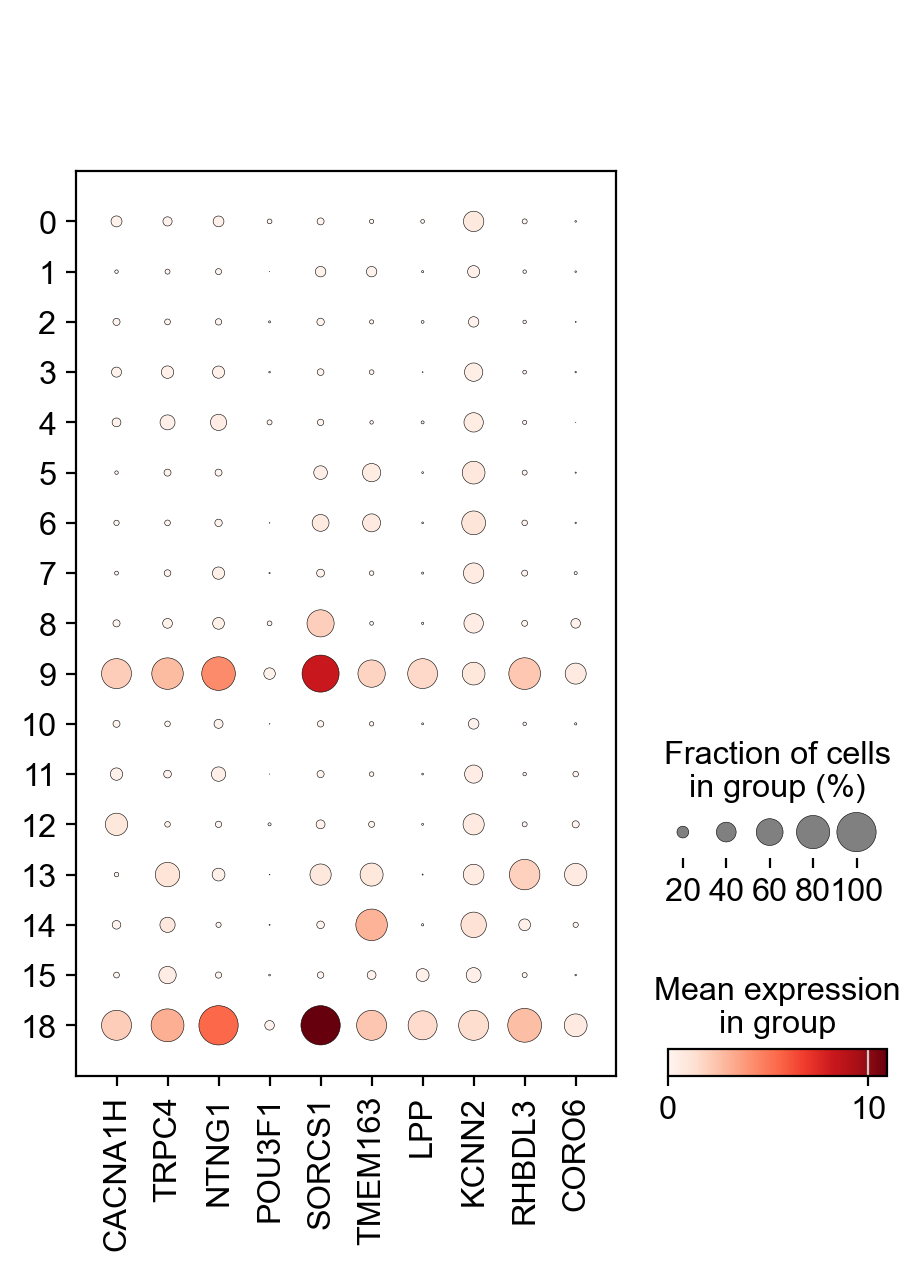

In [29]:
sc.pl.dotplot(
    adata_opossum, 
    results["binary_genes"][0], 
    groupby="leiden_intra")